In [37]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
propiedades = pd.read_csv('properati.csv')

In [39]:
#Elimino columnas innecesarias
propiedades.drop(['id', 'geonames_id', 'lat-lon', 'properati_url', 'description', 'title', 'image_thumbnail'], axis = 1, inplace = True)
propiedades.head(2)


,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
0,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,NaN,NaN,120000.0,USD,2117340.0,120000.0,333.0,93.0,360.36036,1290.322581,NaN,NaN,NaN
1,2012-10-22,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,NaN,NaN,220000.0,USD,3881790.0,220000.0,220.0,220.0,1000.00000,1000.000000,NaN,NaN,NaN


In [40]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 20 columns):
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           125027 non-null float64
surface_covered_in_m2         152420 non-null float64
price_usd_per_m2              105024 non-null float64
price_per_m2                  131

In [41]:
#Elimino los registros que no sean de Capital Federal o Gran Buenos Aires
capital = propiedades ['state_name'] == 'Capital Federal'
gba = propiedades ['state_name'].str.contains('Bs.As. G.B.A.')
propiedades = propiedades [capital | gba].reset_index()
propiedades.drop("index", axis = 1, inplace = True)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124746 entries, 0 to 124745
Data columns (total 20 columns):
created_on                    124746 non-null object
operation                     124746 non-null object
property_type                 124746 non-null object
place_name                    124711 non-null object
place_with_parent_names       124746 non-null object
country_name                  124746 non-null object
state_name                    124746 non-null object
lat                           75504 non-null float64
lon                           75504 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           89385 non-null float64
surface_covered_in_m2         109180 non-null float64
price_usd_per_m2              79108 non-null float64
price_per_m2                  98873 n

In [42]:
#Compruebo que solo haya capital y gba
propiedades.groupby('state_name').agg(np.size)['operation']

state_name
Bs.As. G.B.A. Zona Norte    39888
Bs.As. G.B.A. Zona Oeste    22571
Bs.As. G.B.A. Zona Sur      18135
Capital Federal             44152
Name: operation, dtype: int64

In [43]:
def calcularPrecioM2(fila):
    """Recibe una lista con precio total, superficie total, superficie cubierta y precio por metro cuadrado,
    y calcula este ultimo a partir de los anteriores, cuando es posible"""
    precio_total,superficie_total,superficie_cubierta,precio_m2 = fila
    if (np.isnan(precio_m2)):
        if (superficie_total and not np.isnan(superficie_total)):
            return precio_total/superficie_total
        if(superficie_cubierta and not np.isnan(superficie_cubierta)):
            return precio_total/superficie_cubierta
    return precio_m2

In [44]:
#Calculo el precio por metro cuadrado a partir del precio total y la superficie
propiedades.loc[:,'price_usd_per_m2'] = propiedades.loc[:,['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2']].apply(calcularPrecioM2,axis = 1)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124746 entries, 0 to 124745
Data columns (total 20 columns):
created_on                    124746 non-null object
operation                     124746 non-null object
property_type                 124746 non-null object
place_name                    124711 non-null object
place_with_parent_names       124746 non-null object
country_name                  124746 non-null object
state_name                    124746 non-null object
lat                           75504 non-null float64
lon                           75504 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           89385 non-null float64
surface_covered_in_m2         109180 non-null float64
price_usd_per_m2              103159 non-null float64
price_per_m2                  98873 

como es el precio por metro cuadrado en cada zona?
cuales son los barrios con mayor promedio?

In [45]:
tiene_precio = propiedades['price_usd_per_m2'].notnull()
precio_por_zona = propiedades[tiene_precio].loc[:,['state_name','price_usd_per_m2']].groupby('state_name').agg([np.size,np.mean])
precio_por_zona

price_usd_per_m2             
                                     size         mean
state_name                                            
Bs.As. G.B.A. Zona Norte          36018.0  2300.580157
Bs.As. G.B.A. Zona Oeste          15868.0  2183.777937
Bs.As. G.B.A. Zona Sur            12873.0  2827.342306
Capital Federal                   38400.0  3250.273159

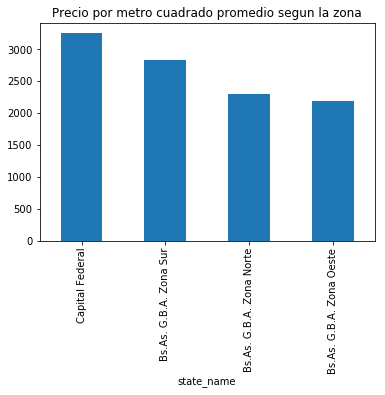

In [46]:
precio_por_zona[('price_usd_per_m2','mean')].sort_values(ascending = False).plot(kind='bar', title = "Precio por metro cuadrado promedio segun la zona")

In [47]:
precios_capital = propiedades[tiene_precio].loc[propiedades.state_name == 'Capital Federal',['place_name','price_usd_per_m2']]
precios_capital = precios_capital.groupby('place_name').agg([np.size,np.mean])
precios_capital.describe()

price_usd_per_m2              
                  size          mean
count        62.000000     62.000000
mean        619.354839   3373.051670
std         734.647169   2851.645024
min           3.000000    874.195822
25%         115.500000   2171.653795
50%         340.500000   2546.540091
75%         736.500000   3287.791290
max        3233.000000  18946.638466

In [50]:
#Tomamos solo aquellos barrios que tengan mas de 300 publicaciones
precios_capital = precios_capital[precios_capital[('price_usd_per_m2','size')] > 300]

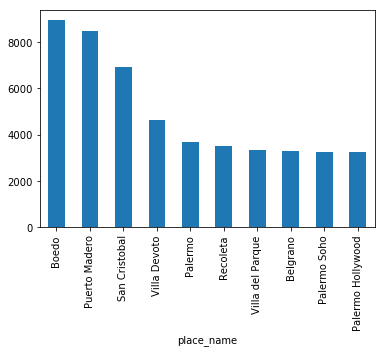

In [52]:
precios_capital[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar')